**essay headline**

# Introduction

## 背景
写作要点：
1. 火灾的危害和火灾响应时间的重要性
2. 国际火灾响应时间的标准，伦敦的标准
3. 引入空间正义理论和可达性理论，表明现实中火灾响应时间也存在地理空间上的差异

新闻：格伦菲尔2017年火灾

## 意义
1. 以伦敦作为研究地区的优点和好处
2. 对政策指定提供参考和建议

## Research Question
1. 明确提出你的研究问题：
  - 不同区域之间是否存在显著的消防响应时间差异？
  - 哪些因素可能导致这些差异？
2. 制定具体的研究目标和假设: 引入社会因素（有文献支撑，并在其基础上进行创新）

# Leterture Review

## 核心研究：关于响应时间和空间分布
1. Hassler et al. (2024): 研究瑞典的实际与估计响应时间差异，发现城市地区的反应时间更高。
2. Goodman et al. (2021): 分析低交通街区对伦敦消防响应时间的影响，发现交通管理对消防服务的不存在显著影响。

## 关于社会经济
1. Taylor (2017): 利用时空分析模型研究人口密度和交通流对伦敦消防服务效率的影响。
2. LeBlanc and Miller (2019): 分析美国社会经济条件对火灾响应结果的影响，发现低收入社区的火灾损失更严重。

## 关于空间正义
1. Lucy (1981): 提出了公平与效率的平衡理论，强调资源应优先分配给高风险地区。
2. Barros and Pereira (2014): 研究地理不平等如何影响服务覆盖。

## 现有文献的贡献及空白
写作要点：
1. 现有文献的局限性
2. 研究的创新点

# Data

## 数据来源
1. 主要数据：伦敦火灾响应时间（来源：london database)
2. 辅助数据：社会经济数据 (来源：)

## 数据描述和可视化
1. 数据描述：时间范围，地区范围，数据列含义，有用的变量
2. 地图显示火灾响应时间和其他有用数据

# Methodology
1. 分析框架：
  - 区域响应时间差异分析。
  - 社会经济因素对响应时间的影响。
2. 数据分析方法：
  - ANOVA和T检验：比较区域间的响应时间差异。
  - 回归模型：分析社会经济变量（如人口密度、收入）对响应时间的影响。
  - 地理加权回归（GWR）：探索空间变量对响应时间的局部效应。

# Analysis

In [131]:
# 导入包
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [132]:
# 导入数据
# 火灾事件数据，年份，事件类型，地点类型，Borough，响应时长
with open('LFB Incident data from 2018 onwards.csv', 'rb') as file:
    result = chardet.detect(file.read(10000))
    print(result)

fire_data = pd.read_csv('LFB Incident data from 2018 onwards.csv', encoding='ISO-8859-1', usecols=[
    'CalYear', 'IncidentGroup', 'FirstPumpArriving_AttendanceTime', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 
    'PropertyCategory'])
print(fire_data.head())

# 地理信息数据
london_bor = gpd.read_file('London_Borough_Excluding_MHW.shp')

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}
   CalYear    IncidentGroup   PropertyCategory IncGeo_BoroughCode  \
0     2018      False Alarm    Non Residential          E09000003   
1     2018      False Alarm    Non Residential          E09000006   
2     2018             Fire  Outdoor Structure          E09000010   
3     2018  Special Service       Road Vehicle          E09000010   
4     2018             Fire       Road Vehicle          E09000025   

  IncGeo_BoroughName  FirstPumpArriving_AttendanceTime  
0             BARNET                             348.0  
1            BROMLEY                             144.0  
2            ENFIELD                             232.0  
3            ENFIELD                              22.0  
4             NEWHAM                             241.0  


In [133]:
# 数据清理

# 查看数据基本信息
print(fire_data.info())
# 检查是否有缺失值
print(fire_data.isnull().sum())

# 删除响应时间（FirstPumpArriving_AttendanceTime）缺失的记录
fire_data2 = fire_data.dropna(subset=['FirstPumpArriving_AttendanceTime'])

# 删除过于小的反应时间记录（＜30秒）
fire_data2 = fire_data2[fire_data2['FirstPumpArriving_AttendanceTime'] >= 30]

# 筛选一下2018-2023年的数据
fire_data2 = fire_data2[fire_data2['CalYear'] < 2024]

# 筛选一下fire数据
fire_only_data = fire_data2[fire_data2['IncidentGroup'] == 'Fire']
fire_only_data.to_csv('cleaned_fire_data.csv', index=False)

# 筛选一下false alarm数据
false_only_data = fire_data2[fire_data2['IncidentGroup'] == 'False Alarm']
false_only_data.to_csv('cleaned_false_data.csv', index=False)

# 筛选一下special数据
special_only_data = fire_data2[fire_data2['IncidentGroup'] == 'Special Service']
special_only_data.to_csv('cleaned_special_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783134 entries, 0 to 783133
Data columns (total 6 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CalYear                           783134 non-null  int64  
 1   IncidentGroup                     783128 non-null  object 
 2   PropertyCategory                  783128 non-null  object 
 3   IncGeo_BoroughCode                783134 non-null  object 
 4   IncGeo_BoroughName                783134 non-null  object 
 5   FirstPumpArriving_AttendanceTime  738816 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 35.8+ MB
None
CalYear                                 0
IncidentGroup                           6
PropertyCategory                        6
IncGeo_BoroughCode                      0
IncGeo_BoroughName                      0
FirstPumpArriving_AttendanceTime    44318
dtype: int64


In [ ]:
# 排除异常值：响应时间 <30 秒或 >900 秒（数据依据：The Impact of 2020 Low Traffic Neighbourhoods on Fire Service Emergency Response Times, in London, UK）
fire_data3 = fire_data2[(fire_data['FirstPumpArriving_AttendanceTime'] >= 30) &
                      (fire_data['FirstPumpArriving_AttendanceTime'] <= 900)]
print(fire_data3.info())

# 保存一下本地数据
fire_data3.to_csv('nonout_fire_data.csv', index=False)

C:\Users\hp\AppData\Local\Temp\ipykernel_10352\2060482968.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fire_data3 = fire_data2[(fire_data['FirstPumpArriving_AttendanceTime'] >= 30) &


<class 'pandas.core.frame.DataFrame'>
Index: 623345 entries, 0 to 670992
Data columns (total 6 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CalYear                           623345 non-null  int64  
 1   IncidentGroup                     623345 non-null  object 
 2   PropertyCategory                  623345 non-null  object 
 3   IncGeo_BoroughCode                623345 non-null  object 
 4   IncGeo_BoroughName                623345 non-null  object 
 5   FirstPumpArriving_AttendanceTime  623345 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 33.3+ MB
None


In [ ]:
# 查看 PropertyCategory 列中的唯一值
unique_values = fire_data3['PropertyCategory'].unique()
print(f"PropertyCategory 列中共有 {len(unique_values)} 种唯一值：")
print(unique_values)

# 查看每个值的计数
value_counts = fire_data3['PropertyCategory'].value_counts()
print("\n每个类别的计数：")
print(value_counts)

PropertyCategory 列中共有 9 种唯一值：
['Non Residential' 'Outdoor Structure' 'Road Vehicle' 'Outdoor' 'Dwelling'
 'Other Residential' 'Aircraft' 'Boat' 'Rail Vehicle']

每个类别的计数：
PropertyCategory
Dwelling             333340
Non Residential      134183
Outdoor               49751
Road Vehicle          41742
Other Residential     33505
Outdoor Structure     29627
Rail Vehicle            544
Aircraft                345
Boat                    308
Name: count, dtype: int64


In [ ]:
# 按 PropertyCategory 汇总统计
property_summary = fire_data3.groupby('PropertyCategory')['FirstPumpArriving_AttendanceTime'].agg(['mean', 'median', 'std', 'count'])
print(property_summary)

                         mean  median         std   count
PropertyCategory                                         
Aircraft           322.031884   313.0  109.417999     345
Boat               342.558442   316.0  136.959134     308
Dwelling           308.892371   294.0  114.122354  333340
Non Residential    304.293480   287.0  121.006336  134183
Other Residential  288.154156   275.0  107.579170   33505
Outdoor            348.839501   328.0  141.466383   49751
Outdoor Structure  321.726905   301.0  129.682434   29627
Rail Vehicle       286.963235   273.0  110.843869     544
Road Vehicle       336.779479   315.0  140.146588   41742


In [120]:
# 根据borough来看反应时间

# 计算每个 borough 的平均响应时间
fire_data3.rename(columns={'IncGeo_BoroughName': 'Borough'}, inplace=True)
fire_data3['Borough'] = fire_data3['Borough'].str.strip().str.upper() 

Borough_response_time = fire_data3.groupby('Borough')['FirstPumpArriving_AttendanceTime'].mean().reset_index()
Borough_response_time.columns = ['Borough', 'AvgResponseTime']

london_bor.rename(columns={'NAME': 'Borough'}, inplace=True)
london_bor['Borough'] = london_bor['Borough'].str.strip().str.upper() 

london_bor = london_bor.merge(Borough_response_time, on='Borough', how='left')  # 合并数据，left join 

# 可视化一下
plt.figure(figsize=(10, 12))
london_bor.plot(column='AvgResponseTime', cmap='OrRd', legend=True, 
               legend_kwds={'label': "Average Response Time (seconds)", 'orientation': "horizontal"})
plt.title('Average Fire Response Time by Borough in London')
plt.axis('off')
plt.show()

# 例如，绘制箱线图以查看不同 borough 之间的响应时间差异
plt.figure(figsize=(14, 8))
sns.boxplot(data=fire_data3, x='Borough', y='FirstPumpArriving_AttendanceTime')
plt.xticks(rotation=90)
plt.xlabel('Borough')
plt.ylabel('First Pump Arriving Attendance Time (seconds)')
plt.title('Distribution of Fire Response Time by Borough in London')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_10352\2124977633.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_data3.rename(columns={'IncGeo_BoroughName': 'Borough'}, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_10352\2124977633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_data3['Borough'] = fire_data3['Borough'].str.strip().str.upper()


MergeError: Passing 'suffixes' which cause duplicate columns {'AvgResponseTime_x'} is not allowed.

C:\Users\hp\AppData\Local\Temp\ipykernel_10352\2079718479.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_data3['Region'] = london_bor['Borough'].apply(


<Figure size 1000x1200 with 0 Axes>

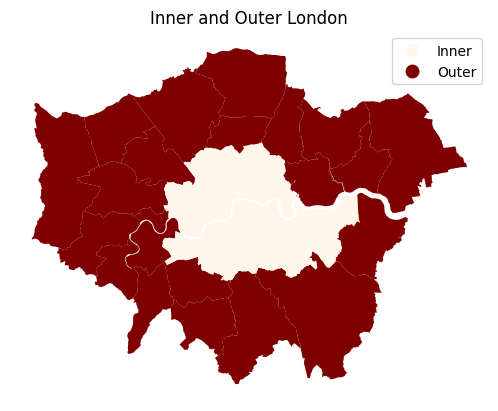

In [100]:
# 区分两个地区来进行分析，inner 和 outer
# 定义 Inner 和 Outer Borough 列表
inner_boroughs = [
    'CAMDEN', 'GREENWICH', 'HACKNEY', 'HAMMERSMITH AND FULHAM', 'ISLINGTON',
    'KENSINGTON AND CHELSEA', 'LAMBETH', 'LEWISHAM', 'SOUTHWARK', 'TOWER HAMLETS',
    'WANDSWORTH', 'WESTMINSTER', 'CITY OF LONDON'
]
outer_boroughs = [
    'BARKING AND DAGENHAM', 'BARNET', 'BEXLEY', 'BRENT', 'BROMLEY', 'CROYDON',
    'EALING', 'ENFIELD', 'HARINGEY', 'HARROW', 'HAVERING', 'HILLINGDON',
    'HOUNSLOW', 'KINGSTON UPON THAMES', 'MERTON', 'NEWHAM', 'REDBRIDGE',
    'RICHMOND UPON THAMES', 'SUTTON', 'WALTHAM FOREST'
]

# 添加分类列
fire_data3['Region'] = london_bor['Borough'].apply(
    lambda x: 'Inner' if x in inner_boroughs else 'Outer' if x in outer_boroughs else 'Unknown'
)

london_bor['Region'] = london_bor['Borough'].apply(
    lambda x: 'Inner' if x in inner_boroughs else 'Outer' if x in outer_boroughs else 'Unknown'
)

# 检查分类结果
plt.figure(figsize=(10, 12))
london_bor.plot(column='Region', cmap='OrRd', legend=True, )
plt.title('Inner and Outer London')
plt.axis('off')
plt.show()

  Region  AvgResponseTime
0  Inner       289.912867
1  Outer       332.531856


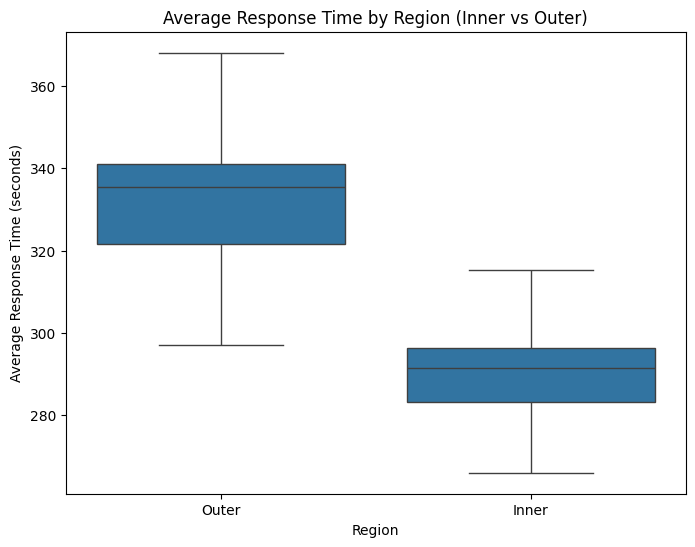

In [ ]:
# 按 Region 计算平均响应时间
region_summary = london_bor.groupby('Region')['AvgResponseTime'].mean().reset_index()
print(region_summary)

# 绘制箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(x='Region', y='AvgResponseTime', data=london_bor)
plt.title('Average Response Time by Region (Inner vs Outer)')
plt.xlabel('Region')
plt.ylabel('Average Response Time (seconds)')
plt.show()


In [ ]:
# 筛选数据
inner_response_time = fire_data3[fire_data3['Region'] == 'Inner']['FirstPumpArriving_AttendanceTime']
outer_response_time = fire_data3[fire_data3['Region'] == 'Outer']['FirstPumpArriving_AttendanceTime']

# t 检验
t_stat, p_value = ttest_ind(inner_response_time, outer_response_time, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 0.12077817908625428, P-value: 0.9050076238662863


这表明：
P-value 大于 0.05：没有足够的统计证据表明 Inner London 和 Outer London 的火灾响应时间存在显著差异。
T-statistic 的值较小：说明两个区域的响应时间均值相近。

或许应该考虑将火灾场所进行分类，或者加入其他两种事件。
先看一下密度范围

C:\Users\hp\AppData\Local\Temp\ipykernel_10352\1533318105.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(inner_response_time, label='Inner London', shade=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_10352\1533318105.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(outer_response_time, label='Outer London', shade=True)


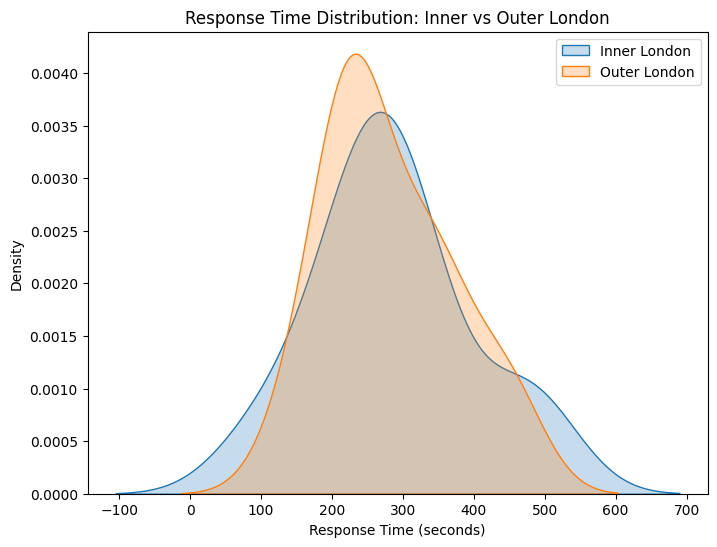

In [ ]:
# 绘制密度图
plt.figure(figsize=(8, 6))
sns.kdeplot(inner_response_time, label='Inner London', shade=True)
sns.kdeplot(outer_response_time, label='Outer London', shade=True)
plt.title('Response Time Distribution: Inner vs Outer London')
plt.xlabel('Response Time (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()

响应时间的分布：

Inner London（蓝线）：响应时间的分布稍微偏向右侧（较高响应时间），显示出略宽的尾部，说明一些事件的响应时间更长。
Outer London（橙线）：分布稍微偏向左侧（较低响应时间），且峰值更高，说明响应时间更集中于较短的区间。
分布重叠：

两个分布有较大的重叠区域，表明两个区域的响应时间在整体上相似，没有特别显著的差异。
从分布来看，Outer 的响应时间稍快（分布略靠左），但差异较小。
峰值差异：

Outer London 的密度峰值略高，说明响应时间主要集中在一个相对短的区间。
Inner London 的密度较平坦，表明响应时间的分布范围更广。
图表说明的意义
响应时间一致性：

Outer London 的响应时间分布更集中，可能是因为 Outer London 的事件场景或距离较一致，资源分配更加均匀。
Inner London 的分布较广，可能是由于事件复杂性（例如人口密度高、道路拥堵等因素）导致响应时间差异较大。
资源分配和地理特性：

Outer London 更大的区域可能有相对较少的事件发生点，这可能使得消防资源分配更有效率。
Inner London 的人口密集度和复杂的城市环境可能导致响应时间分布更宽

In [ ]:
# 按 Borough 分组
grouped_data = [group['FirstPumpArriving_AttendanceTime'].values for name, group in fire_data3.groupby('Borough')]

# 执行 ANOVA 检验
f_stat, p_value = f_oneway(*grouped_data)
print(f"ANOVA F-statistic: {f_stat}, P-value: {p_value}")

ANOVA F-statistic: 936.9986969263987, P-value: 0.0


                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
        group1                 group2          meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------------------------
  BARKING AND DAGENHAM                 BARNET    1.9432    1.0   -3.1571   7.0434  False
  BARKING AND DAGENHAM                 BEXLEY   -1.3661    1.0   -7.0264   4.2943  False
  BARKING AND DAGENHAM                  BRENT    3.5805 0.7437   -1.6203   8.7813  False
  BARKING AND DAGENHAM                BROMLEY    15.186    0.0    9.8895  20.4824   True
  BARKING AND DAGENHAM                 CAMDEN   -41.636    0.0  -46.5549 -36.7171   True
  BARKING AND DAGENHAM         CITY OF LONDON  -55.6331    0.0  -62.6476 -48.6187   True
  BARKING AND DAGENHAM                CROYDON  -28.9703    0.0  -33.9288 -24.0118   True
  BARKING AND DAGENHAM                 EALING   -14.034    0.0  -19.1491   -8.919   True
  BARKING AND DAGENHA

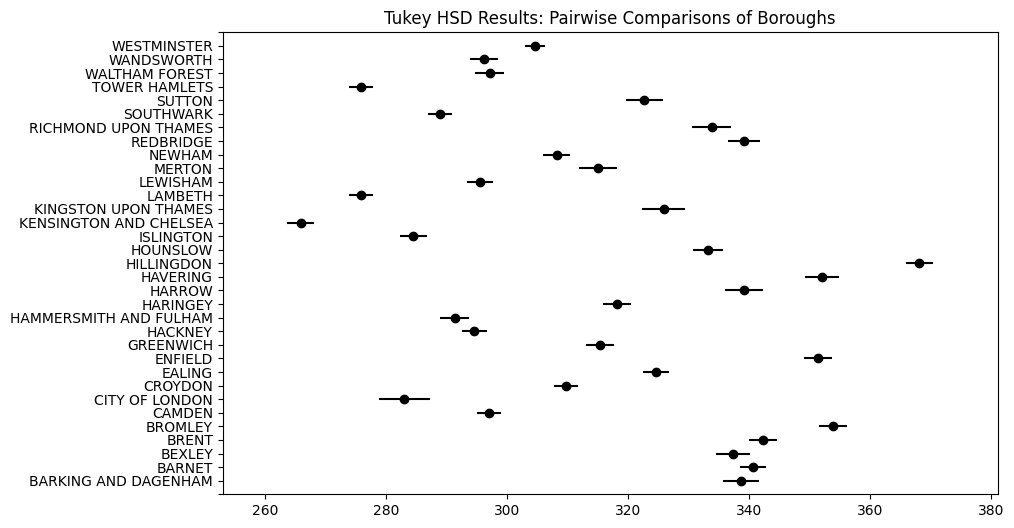

C:\Users\hp\AppData\Local\Temp\ipykernel_10352\338156716.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Borough', y='AvgResponseTime', data=borough_avg, ci=None)


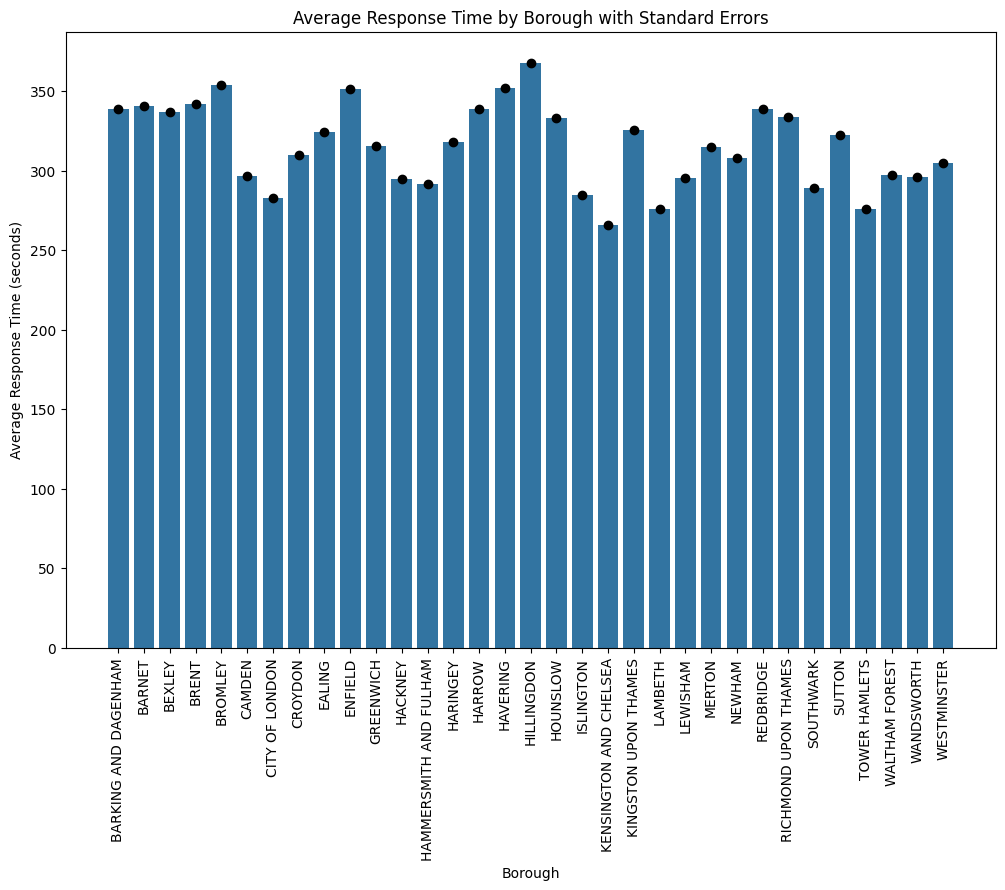

In [ ]:
# 执行 Tukey HSD 检验
tukey = pairwise_tukeyhsd(endog=fire_data3['FirstPumpArriving_AttendanceTime'], 
                          groups=fire_data3['Borough'], 
                          alpha=0.05)
print(tukey.summary())

# 可视化 Tukey HSD 检验结果
tukey.plot_simultaneous()
plt.title('Tukey HSD Results: Pairwise Comparisons of Boroughs')
plt.show()

# 计算每个 Borough 的平均响应时间及标准误差
borough_avg = fire_data3.groupby('Borough')['FirstPumpArriving_AttendanceTime'].agg(['mean', 'sem']).reset_index()
borough_avg.rename(columns={'mean': 'AvgResponseTime', 'sem': 'StandardError'}, inplace=True)

# 绘制柱状图
plt.figure(figsize=(12, 8))
sns.barplot(x='Borough', y='AvgResponseTime', data=borough_avg, ci=None)
plt.errorbar(x=range(len(borough_avg)), y=borough_avg['AvgResponseTime'], yerr=borough_avg['StandardError'], fmt='o', color='black')
plt.xticks(rotation=90)
plt.title('Average Response Time by Borough with Standard Errors')
plt.xlabel('Borough')
plt.ylabel('Average Response Time (seconds)')
plt.show()

结果证明borough之间具有显著差异性
下面进行k聚类来分析

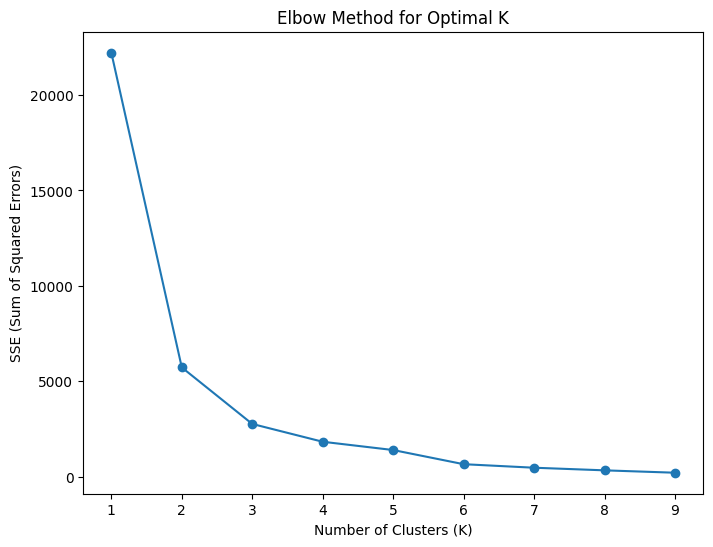

In [ ]:
# 肘部法确定最佳聚类数
sse = []  # 保存每个 K 值的总误差平方和
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(london_bor[['AvgResponseTime']])
    sse.append(kmeans.inertia_)

# 绘制肘部法图像
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal K')
plt.show()


                   Borough  AvgResponseTime  StandardError  Cluster
6           CITY OF LONDON       283.030634       1.308253        0
7                  CROYDON       309.693477       0.750075        0
5                   CAMDEN       297.027764       0.700687        0
11                 HACKNEY       294.601895       0.694377        0
12  HAMMERSMITH AND FULHAM       291.398496       0.794994        0
22                LEWISHAM       295.501959       0.760955        0
18               ISLINGTON       284.525352       0.714047        0
31              WANDSWORTH       296.186897       0.811095        0
24                  NEWHAM       308.196243       0.820837        0
27               SOUTHWARK       288.968559       0.639262        0
30          WALTHAM FOREST       297.128982       0.932892        0
29           TOWER HAMLETS       275.847844       0.670298        0
21                 LAMBETH       275.852184       0.654571        0
19  KENSINGTON AND CHELSEA       265.945372     

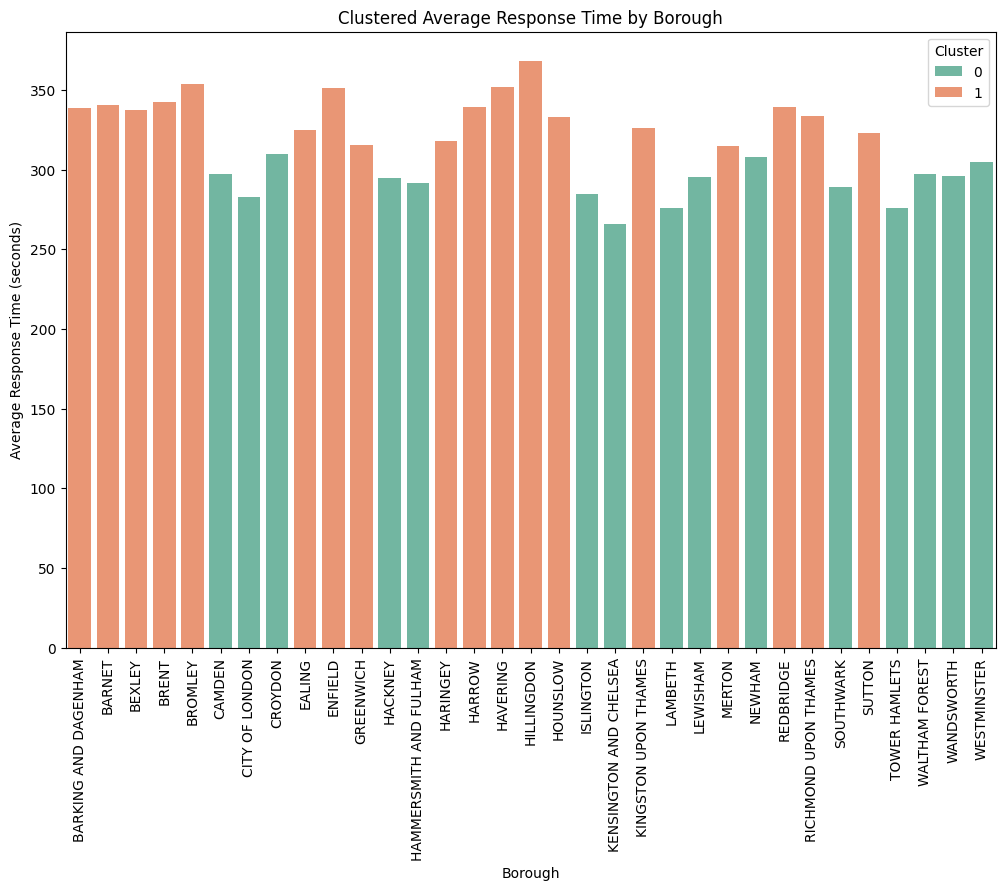

<Figure size 1000x1200 with 0 Axes>

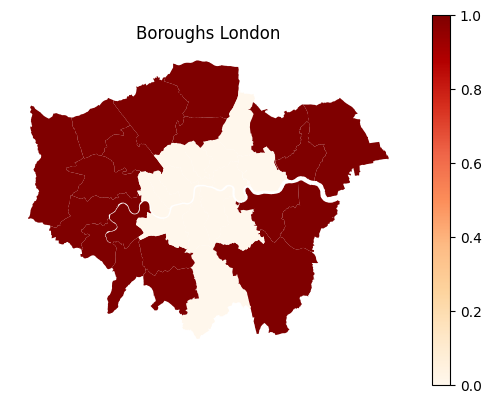

In [123]:
# 执行 K-means 聚类
kmeans = KMeans(n_clusters=2, random_state=42)
borough_avg['Cluster'] = kmeans.fit_predict(borough_avg[['AvgResponseTime']])

# 查看聚类结果
print(borough_avg.sort_values('Cluster'))

# 绘制柱状图
plt.figure(figsize=(12, 8))
sns.barplot(x='Borough', y='AvgResponseTime', hue='Cluster', data=borough_avg, dodge=False, palette='Set2')
plt.xticks(rotation=90)
plt.title('Clustered Average Response Time by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Response Time (seconds)')
plt.show()

# 删除可能重复的列
if 'AvgResponseTime' in london_bor.columns:
    london_bor.drop(columns=['AvgResponseTime'], inplace=True)
london_bor = london_bor.merge(borough_avg, on='Borough', how='left')  # 合并数据，left join 

# 检查分类结果
plt.figure(figsize=(10, 12))
london_bor.plot(column='Cluster', cmap='OrRd', legend=True, )
plt.title('Boroughs London')
plt.axis('off')
plt.show()

In [ ]:
fire_data3 = fire_data3.merge(london_bor[['Borough', 'Cluster']], on='Borough', how='left')

# 筛选数据
c1_response_time = fire_data3[fire_data3['Cluster'] == '1']['FirstPumpArriving_AttendanceTime']
c0_response_time = fire_data3[fire_data3['Cluster'] == '0']['FirstPumpArriving_AttendanceTime']

# t 检验
t_stat, p_value = ttest_ind(c1_response_time, c0_response_time, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: nan, P-value: nan


C:\Users\hp\AppData\Local\Temp\ipykernel_10352\376116359.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = ttest_ind(c1_response_time, c0_response_time, equal_var=False)
